# [SF-DST Credit Scoring](https://www.kaggle.com/c/sf-dst-scoring)

#### Прогнозирование вероятности дефолта заемщика
> InClass Prediction Competition

#### By: Natalya Lisitskaya

## Содержание

<a href='#2'> Import & read data
    
<a href='#4'> Исходные данные
    
<a href='#3'>  Functions
    
<a href='#1'> Первичный осмотр данных
    
<a href='#6'> Подготовка датасета    
   
<a href='#7'> Генерация новых признаков
    
<a href='#9'> Простейшая логистическая модель и выбор метрик
    
<a href='#8'> EDA
    
<a href='#5'> Корреляционный анализ
    
<a href='#10'> Настройка гиперпараметров логистической регрессии
 
<a href='#12'> Нормализация и стандартизация
    
<a href='#11'> Песочница для экспериментов
    
<a href='#13'> Выводы

<a id='2'></a> 
## Import & read data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
#loading the required libraries

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
from collections import OrderedDict
from datetime import datetime, timedelta
import pandas_profiling

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100) # показывать больше строк
pd.set_option('display.max_columns', 100) # показывать больше колонок 

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# fix RANDOM_SEED
RANDOM_SEED = 42
DATA_DIR = '/kaggle/input/sf-dst-scoring'
# fix version:
!pip freeze > requirements.txt

In [3]:
df_train = pd.read_csv(DATA_DIR + '/train.csv')
df_test = pd.read_csv(DATA_DIR + '/test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [4]:
# For the correct processing of features, combine train and test sets into a one dataset

df_train['sample'] = 1  # train
df_test['sample'] = 0  # test
df_test['default'] = 0 # в тестовых данных нет значения дефолта

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # combine sets

In [5]:
df_train.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  sample  
0             2   18000    4           1                N        0       1  
1             3   19000    4           1                N        0       1  
2             2   30000    1           4                Y        0       1  
3             3   10000    1           3                N        0       1  
4             3   30000    1           4                Y        0       1

In [6]:
df_test.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  sample  default  
0             2   50000    1           4                N       0        0  
1             2    5000    4           3                N       0        0  
2             2   30000    1           3                Y       0        0  
3             2   17000    1           3                N       0        0  
4             3  120000    1           3                N       0        0

In [7]:
sample_submission.head()

client_id   default
0      66799  0.441004
1      25379  0.138092
2      28825  0.373370
3      37530  0.476501
4       4264  0.304640

<a id='4'></a> 
## Исходные данные

**В предложенном проекте необходимо построить скоринг-модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого необходимо определить значимые параметры заемщика.**

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

<a id='3'></a> 
## Функции

In [8]:
def split_data(df_preproc):
    '''
    Returns
    X, y, test_data
    '''
    
    # Теперь выделим тестовую часть
    train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
    test_data = df_preproc.query('sample == 0').drop(['sample', 'default'], axis=1)
    '''
    y = train_data.Rating.values            # наш таргет
    X = train_data.drop(['Rating'], axis=1)
    '''
    return train_data, test_data

def preproc_data(df, cat_cols, num_cols, bin_cols):
    '''
    
    Parameters
    ----------
    df : исходный общий датафрейм

    Returns
    -------
    X_train : 
    X_test :
    y_train : 
    y_test : 
        подготовленные датафреймы: стандартизация и onehot - кодирование
    '''
    df_train, df_test = split_data(df)
    
    # Создадим массив числовых признаков и стандартизируем его при помощи StandardScaler:
    standart_scaler = StandardScaler()
    X_train_num = standart_scaler.fit_transform(df_train[num_cols])
    X_test_num = standart_scaler.fit_transform(df_test[num_cols])
    print(X_train_num.shape, X_test_num.shape)
    poly = PolynomialFeatures(degree=5).fit(X_train_num)
    X_train_poly = poly.transform(X_train_num)
    X_test_num = poly.transform(X_test_num)
    print(X_train_poly.shape, X_test_num.shape)
    
    # Создадим массив категориальных признаков и сделаем OneHotEncoding:
    ohe = OneHotEncoder(sparse=False).fit(df[cat_cols])
    X_train_cat = ohe.transform(df_train[cat_cols])
    X_test_cat = ohe.transform(df_test[cat_cols])
    print(X_train_cat.shape, X_test_cat.shape)
    
    # Создадим массив бинарных признаков:
    X_train_bin = df_train[bin_cols].values
    X_test_bin = df_test[bin_cols].values
    print(X_train_bin.shape, X_test_bin.shape)
    
    # Объединяем в одно признаковое пространство тестовую выборку:
    X_test = np.hstack([X_test_num, X_test_cat,  X_test_bin])
    X_test.shape
    
    # Объединяем в одно признаковое пространство тренировочную выборку: 
    X = np.hstack([X_train_poly, X_train_cat,  X_train_bin])
    y = df_train['default'].values
    print(X.shape, y.shape)
    ####################
    # use f_classif (the default) and SelectPercentile to select 50% of features
    select = SelectPercentile(percentile=60)
    select.fit(X, y)
    # transform training set
    print('SelectPercentile:', X.shape, X_test.shape)
    X_selected = select.transform(X)
    print('X.shape,X_selected.shape=', X.shape,X_selected.shape)
    X_test_selected = select.transform(X_test)
    print('X_test.shape,X_test_selected.shape=', X_test.shape,X_test_selected.shape)
    
    print(X_selected.shape, y.shape, X_test_selected.shape )
    ###################
    #stratify=y,
    X_train, X_val, y_train, y_val = train_test_split(X_selected, y, stratify=y, test_size=0.20, random_state=RANDOM_SEED)
    
    return X_train, df_test, y_train, X_val, y_val, X_test_selected
    
def get_boxplot(df: pd.DataFrame, column: object, ax_y='default') -> None:
    '''
    Функция для отображения boxplot-графиков для номинативных и смешанных переменных
    '''
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df,ax=ax)
    cnt = df[column].value_counts()
    medians = df.groupby([column])[ax_y].median()
    vertical_offset = df.groupby([column])[ax_y].median() 
    x = df[column].unique()
    x = list(filter(lambda v: v==v, x))
    if df.loc[:, col].dtypes != np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, medians.loc[ytick]-vertical_offset[ytick], cnt.loc[ytick], 
                    horizontalalignment='center',size=15, color='w',weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

def count_gaps(df):
    # Считаем процент пропусков
    per_nans = pd.DataFrame(1-df.count()/df.shape[0]).reset_index().rename({0:'percent'}, \
                                                    axis=1).sort_values('percent', ascending=False).query('percent>0')
    # Строим график относительного количества пропущенных значений:
    fig, ax = plt.subplots(figsize = (10, 8))
    bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=1.0, ci=None)
    for ytick in bar_plot.get_yticks():
            bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2))+' %', 
                        horizontalalignment='center',size=12, color='black',weight='semibold')
    plt.title('Относительное количество пропусков')
    plt.ylabel('')
    plt.xlabel('Percent', fontsize=12)
    plt.show()

    
def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool=True) -> tuple:
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = round(df[column].quantile(0.25),3)
    perc75 = round(df[column].quantile(0.75),3)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print(column)
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)

def histogram_boxplot(feature, figsize=(15,10), bins=None):
    f,(ax_box,ax_hist)=plt.subplots(nrows=2,sharex=True, gridspec_kw={'height_ratios':(.25,.75)},figsize=figsize)                                  
                                                                                           
    sns.distplot(feature,kde=False,ax=ax_hist,bins=bins) 
    
    sns.boxplot(feature,ax=ax_box, color='Pink')
    ax_hist.axvline(np.mean(feature),color='g',linestyle='-')
    ax_hist.axvline(np.median(feature),color='y',linestyle='--')

def grouped_boxplots(df,feature1,feature2,goal):
    sns.set_theme(style="ticks", palette="pastel")

    # Draw a nested boxplot to show feature1 by feature2
    sns.boxplot(x=feature1, y=feature2,
                hue=goal, palette=["m", "g"],
                data=df)
    sns.despine(offset=10, trim=True)
    
def show_confusion_matrix(y_val, y_pred):
    '''
    Процедура для рисования матрицы
    '''
    s = confusion_matrix(y_val, y_pred).sum()
    #group_names_pr =[str(round((i/s)*100))+'%' for i in confusion_matrix(y_val, y_pred).flatten()]
    group_names = ['TN', 'FP', 'FN', 'TP']
    #group_names = group_names + group_names_pr
    group_1 = ['{0:0.0f}'.format(i) for i in confusion_matrix(y_val, y_pred).flatten()]
    group_2 = ['{0:0.2f}%'.format(round((i/s)*100,2)) for i in confusion_matrix(y_val, y_pred).flatten()]
    group_counts = [f'{v1}\n{v2}' for v1, v2 in zip(group_1, group_2)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=labels, fmt='', cmap="YlGnBu");
    
    
    
def log_features(df_col,column_name, df_y, bins_n=10, feature_name=None):
    # гистограмма распределения: 
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    sns.distplot(np.log(df_col.values+1), bins=bins_n, color='#a1c9e0')
    plt.title(' логарифм от ' + column_name, fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Quantity (frequency)')

    # boxplot: распределение признака по целевой переменной
    plt.subplot(122)
    sns.boxplot(x=df_y, y=df_col)
    plt.title(column_name + ' distribution by default', fontsize=15)
    plt.xlabel('default')
    plt.ylabel(column_name)

    plt.show()
    return ''
    
def clear_dataset():
    '''
    Функция читает датасеты, объединяет, заполняет пропуски,
    преобразует дату и оцифровывает.
    Возвращает объединенный датасет полностью готовый к преобразованиям
    '''
    
    df_train = pd.read_csv(DATA_DIR + '/train.csv')
    df_test = pd.read_csv(DATA_DIR + '/test.csv')
    # For the correct processing of features, combine train and test sets into a one dataset

    df_train['sample'] = 1  # train
    df_test['sample'] = 0  # test
    df_test['default'] = 0 # в тестовых данных нет значения дефолта
    df = df_test.append(df_train, sort=False).reset_index(drop=True)  # combine sets
    
    df['app_date'] = pd.to_datetime(df['app_date'])
    df['mm'] = df['app_date'].dt.month
    #df['yy'] = df['app_date'].dt.year # year only 2014
    
    df['doy'] = df['app_date'].dt.dayofyear
    df['dow'] = df['app_date'].dt.dayofweek
    df['mdow'] = df['mm']*df['dow']
    df['weekend'] = df['dow'].apply(lambda x: 1 if x>4 else 0).astype('int8')
    
    df.drop(columns = ['app_date','mm','dow'], inplace=True)
    
    #df['education'].fillna(df['education'].mode()[0],inplace=True)
    df['education'].fillna('NN',inplace=True)
    
    # Для бинарных признаков мы будем использовать LabelEncoder

    label_encoder = LabelEncoder()
    
    for column in bin_cols:
        df[column] = label_encoder.fit_transform(df[column])
    
    df['education'] = label_encoder.fit_transform(df['education'])
    
    return df
    ###################################################################

def pd_cut(dict_cols):
    '''
    Процедура коннвертирует признаки из передаваемого словаря
    при помощи pandas cut.
    Cловарь для каждого признака содержит настройки для дискретизации: метки и интервалы
    '''
    for key in dict_cols:
        df[key] = pd.cut(df[key],bins=dict_cols[key][1],labels=dict_cols[key][0]).astype('int32')
    return

def convert_dataset():  
    '''
    Процедура Конвертации признаков
    '''
    # Преобразование числовых признаков
    # Выбросы
    
    cols_log = ['age','income','bki_request_cnt']#Доп признаки числовые
    for col in cols_log:
        df[col+'_log'] = np.log(1 + df[col])
        
    for col in ['score_bki','income_log','bki_request_cnt_log']: #Выбросы
        low, high = IQR_outlier(df,col)
        df[col] = df[col].apply(lambda x: x if x>low else low)
        df[col] = df[col].apply(lambda x: x if x<high else high)
    
    df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: x if x<8 else 8)
    
    #Словарь настроек для дискретизации признаков
    dict_cols ={'income':[['10', '50', '100','150','200','500','1000'],\
                      [0, 10000, 50000, 100000, 150000,200000,500000,1000000]],\
               'age':[['35', '48','65','75'],\
                     [20, 35, 48, 65, 75]],\
                'bki_request_cnt':[['0','1', '5', '10','15','30','50','100'],\
                                  [-1,0, 1, 5, 10,15,30,50,100]]               
               }
    
    pd_cut(dict_cols) #Вызов процедуры дискретизации
    
    #df.drop(columns = ['income','bki_request_cnt'], inplace=True)
    
    #Преобразование признаков
    df['home_work_address'] = df['home_address']*10+df['work_address']
    df['sna_first_time'] = df['sna']*10+df['first_time']
    df.drop(columns = ['home_address','work_address','sna','first_time'], inplace=True)
    
    df['cars'] = df['car'].astype('int')*10 + df['car_type'].astype('int')
    df.drop(columns = ['car','car_type'], inplace=True)
    
    df['sex_work'] = df['sex'].astype('int')*10 + df['good_work'].astype('int')
    df['sex_age'] = df['sex'].astype('int')*10 + df['age'].astype('int')
     
    #df['dd'] = np.log(1 + df['dd'])
    df['doy'] = np.log(1 + df['doy'])
    #Еще удалить
    #df.drop(columns = ['doy','dd', 'sex', 'weekend'], inplace=True)
    

    return df

def get_auc_lr(X_train, y_train, X_test, y_test, C=1.0, ratio = 0.9, seed=RANDOM_SEED):
    '''
    Функцию возвращает качество модели на отложенной выборке
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
        
    logit = LogisticRegression(solver='newton-cg', max_iter=1000,C=C, n_jobs = -1, random_state=seed)
    
    logit.fit(X_train, y_train)
    
    valid_pred = logit.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, valid_pred)

def _RandomizedSearchCV(): 
    # Создание сетки гиперпараметров

    C = np.logspace(0, 5, 10).tolist()
    param_grid = [
        {'penalty': ['l1'],
         'C' : C,
         'solver': ['liblinear'],
         'class_weight':['none', 'balanced'],
         'multi_class': ['auto','ovr']},
        {'penalty': ['l2'],
         'C' : C,
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
         'class_weight':['none', 'balanced'],
         'multi_class': ['auto','ovr']},
        {'penalty': ['none'],
         'C' : C,
         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
         'class_weight':['none', 'balanced'],
         'multi_class': ['auto','ovr']},
    ]

    log_reg = LogisticRegression(max_iter=200)

    # Создание объекта RandomizedSearchCV

    cv = RandomizedSearchCV(log_reg, param_grid, cv = 5)

    cv.fit(X_train, y_train)

    # Печать настроенных параметров и оценка

    print("Tuned Decision Tree Parameters: {}".format(cv.best_params_))

    print("Best score is {}".format(cv.best_score_))
    #'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'auto', 'class_weight': 'none', 'C': 7742.636826811277
    
    return cv.best_params_, cv.best_score_

def logreg_model():
    #model = LogisticRegression(solver='newton-cg', multi_class='ovr', class_weight=None, C=2154.4346900318847, penalty='none')#0.746
    #{'solver': 'newton-cg', 'penalty': 'none', 'multi_class': 'ovr', 'class_weight': 'none', 'C': 2154.4346900318847}
    
    model = LogisticRegression(max_iter=1000,solver='liblinear', class_weight='balanced', C=1.0, penalty='l1')#0.746
    
    #model = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.7825594022071245, penalty='l2')#0.743
    
    #{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
    #2.154434690031882
    #'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'auto', 'class_weight': 'none', 'C': 7742.636826811277
    #model = LogisticRegression(max_iter=1000,solver='newton-cg', C=7742.636826811277, penalty='l2', multi_class='auto', class_weight=None)#0.747
    
    #{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'ovr', 'class_weight': 'none', 'C': 46.4158883361278}
    #model = LogisticRegression(solver='sag', multi_class='ovr', class_weight='balanced', C=46.4158883361278, penalty='l2')
    
    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_val)
    y_prob = y_prob[:,1]
    
    
    fpr, tpr, threshold = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)
    close_default = np.argmin(np.abs(threshold - 0.5))
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10,\
        label="threshold 0.5", fillstyle="none", c='k', mew=2)
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    print()
    return model

def _GridSearchCV(penalty):
    '''
    Функция регуляризации по GridSearchCV
    с параметрами по умолчанию
    По заданному словарю оказалась ужасно медленной
    '''
    log_reg = LogisticRegression(solver='liblinear', penalty=penalty)

    C_values = {'C': np.logspace(-3, 3, 10)}
    logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
    logreg_grid.fit(X_train, y_train)
    print(logreg_grid.best_params_)
    print(logreg_grid.best_score_)
    results_df = pd.DataFrame(logreg_grid.cv_results_)
    plt.plot(results_df['param_C'], results_df['mean_test_score'])

    # Подписываем оси и график
    plt.xlabel('C')
    plt.ylabel('Test accuracy')
    plt.title('Validation curve, penelty = '+ penalty)
    plt.show()
    y_pred = logreg_grid.best_estimator_.predict(X_val)
    print(confusion_matrix(y_val, y_pred))
    print('F1 score valid:', f1_score(y_val, y_pred))

<a id='1'></a> 
## Первичный осмотр данных
**Первичный анализ сделаем для всех данных, чтобы обнаружить пропуски, уникальные значения, разобьем данные на типы для возможности цифрового кодирования**

In [9]:
profile_report = pandas_profiling.ProfileReport(df)
profile_report

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Беглый просмотр profile - отчета позволяет сделать выводы, что датасет содержит достаточно большое для моделирования количество наблюдений (более 110 тыс) без дубликатов строк, при этом пропуски составляют только 0.4%** 

**Наблюдаемые свойства относятся как к числовому типу, так и категориальному, где выделяется и бинарный тип данных.**

**Распределения числовых свойств не являются нормальными и потребуют дополнительной обработки.**

**Гистограмма целевой функции default явно показывает на дисбаланс выборки: в датасете преобладают наблюдения 0 - класса над классом 1, т.е дефолт наблюдается у 8.5% клиентов, 91.5% - это добропорядочные заемщики.
Это накладывает ограниченя на выбор метрики для оценки модели.**

**Пропуски значений имеются только в поле education, нужно попробовать заменить их модой, при чем в целом по
датасету, т.к они составляют только 0.4%. Eсли бы процент пустых значений был высоким пришлось бы предварительно 
исследовать отличие моды в целом по датасету от моды в группах по различным признакам**

**Столбец app_date требует сразу же пребразования в день, месяц, год, день недели. Сразу можно сделать вывод по частоте употребления цифр 0, 1, 2, 4 при уникальности значений 120 на весь датасет, что в нем представлены данные только 2014 года. Поэтому колонка со значением года просто теряет смысл.**

**Колонки education, car, car_type, sex, foreign_passport требуют перекодировки в цифровой формат**



**Теперь важно определиться с типами данных, поскольку от этого будет зависеть тип кодирования Категориальных данных. Для этого выведем таблицу с исходным типом данных и количеством уникальных значений данного свойства**

In [10]:
d = pd.concat([df.dtypes,df.nunique()],axis=1)
d.columns = ['Type', 'Quality of unique values']
display(d)

Type  Quality of unique values
client_id           int64                    110148
app_date           object                       120
education          object                         5
sex                object                         2
age                 int64                        52
car                object                         2
car_type           object                         2
decline_app_cnt     int64                        24
good_work           int64                         2
score_bki         float64                    102618
bki_request_cnt     int64                        40
region_rating       int64                         7
home_address        int64                         3
work_address        int64                         3
income              int64                      1207
sna                 int64                         4
first_time          int64                         4
foreign_passport   object                         2
sample              int64                         2
default             int64                         2

**Данные можно разделить на бинарные, категориальные и числовые следующим образом:**

In [11]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'weekend']
cat_cols = ['education', 'home_address', 'work_address', 'decline_app_cnt', \
            'first_time', 'sna', 'region_rating', 'dow','mm']
num_cols = ['age', 'income', 'bki_request_cnt','score_bki','dd', 'doy']

<a id='6'></a> 
## Подготовка датасета

**Поскольку данная задача не предполагает работу с временными рядами, то можно удалить столбец app_date, предварительно  преобразовав его в четыре значения:**

   **mm** - месяц (категориальный)
    
   **dd** - день (числовой)
    
   **yy** - год не будем использовать, в датасете только 2014
    
   **dow** - день недели (категориальный)

In [12]:
df['app_date'] = pd.to_datetime(df['app_date'])
df['dd'] = df['app_date'].dt.day
df['mm'] = df['app_date'].dt.month # year only 2014
df['doy'] = df['app_date'].dt.dayofyear
df['dow'] = df['app_date'].dt.dayofweek
df['weekend'] = df['dow'].apply(lambda x: 1 if x>4 else 0).astype('int8')

In [13]:
df.drop(['app_date'], axis = 1, inplace=True)

In [14]:
df.sample(5)

client_id education sex  age car car_type  decline_app_cnt  good_work  \
48600        1171       UGR   M   52   Y        N                0          0   
105940      61389       SCH   F   39   N        N                0          0   
53104        7155       PGR   F   29   N        N                0          0   
30512       37165       SCH   M   47   Y        Y                1          0   
7491        26792       SCH   M   22   N        N                0          0   

        score_bki  bki_request_cnt  region_rating  home_address  work_address  \
48600   -2.024205                3             70             2             3   
105940  -2.024100                1             50             1             2   
53104   -1.750078                3             70             1             2   
30512   -1.034621                2             70             2             3   
7491    -1.764329                3             50             2             3   

        income  sna  first_time foreign_passport  sample  default  dd  mm  \
48600   100000    1           1                N       1        0   5   1   
105940   15000    1           3                N       1        0  11   3   
53104    49000    4           1                N       1        0  14   1   
30512    50000    4           1                N       0        0  13   2   
7491     40000    1           2                N       0        0   3   2   

        doy  dow  weekend  
48600     5    6        1  
105940   70    1        0  
53104    14    1        0  
30512    44    3        0  
7491     34    0        0

**Заполним пропуски в education**

In [15]:
#df['education'].fillna(df['education'].mode()[0],inplace=True)
df['education'].fillna('NN',inplace=True)

**Для бинарных признаков мы будем использовать LabelEncoder чтобы получить колонки с 0 и 1**

**Среди категориальных признаков только education остается не закодированным в числа:**

In [16]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df[bin_cols].head()

sex  car  car_type  foreign_passport  good_work  weekend
0    1    1         1                 0          0        1
1    0    0         0                 0          0        0
2    1    1         1                 1          0        1
3    1    0         0                 0          0        0
4    0    0         0                 0          0        0

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [18]:
df['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NN       478
ACD      291
Name: education, dtype: int64

In [19]:
df['education'] = label_encoder.fit_transform(df['education'])

In [20]:
print(dict(enumerate(label_encoder.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'NN', 3: 'PGR', 4: 'SCH', 5: 'UGR'}


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

**Все столбцы датасета имеют цифровой формат**

In [22]:
df.sample(5)

client_id  education  sex  age  car  car_type  decline_app_cnt  \
10448      35908          1    1   27    0         0                0   
34123      29463          3    0   39    1         1                0   
96522      59255          1    1   35    0         0                0   
90567      36642          4    1   27    1         0                0   
52223      86044          4    1   51    0         0                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
10448          1  -1.219469                0             80             2   
34123          0  -2.384331                7             60             2   
96522          0  -2.049325                3             70             1   
90567          0  -1.602795                1             70             2   
52223          0  -1.709265                0             60             1   

       work_address  income  sna  first_time  foreign_passport  sample  \
10448             3   48000    1           3                 0       0   
34123             3   85000    2           3                 1       0   
96522             2   45000    1           3                 0       1   
90567             3   48000    4           1                 0       1   
52223             3   35000    1           3                 0       1   

       default  dd  mm  doy  dow  weekend  
10448        0  12   2   43    2        0  
34123        0   5   2   36    2        0  
96522        0   7   3   66    4        0  
90567        1  12   2   43    2        0  
52223        0   2   4   92    2        0

<a id='7'></a> 
## Генерация новых признаков

**Представление данных сильно зависит от используемой модели обучения. Поскольку нашей моделью является логистическая регрессия, которая относится к числу линейных моделей, то от нас потребуется помимо представления категориальных признаков в числовые значения,
стандартизация уже существующих числовых признаков.**


**Посмотрим на тип и количество уникальных значений для категориальных признаков:**

In [23]:
d = pd.concat([df[cat_cols].dtypes,df[cat_cols].nunique()],axis=1)
d.columns = ['Type', 'Quality of unique values']
display(d)

Type  Quality of unique values
education        int64                         6
home_address     int64                         3
work_address     int64                         3
decline_app_cnt  int64                        24
first_time       int64                         4
sna              int64                         4
region_rating    int64                         7
dow              int64                         7
mm               int64                         4

**После того как общий датасет содержит только числовые значения и не содержит пропусков на обучающей выборке, произведем обратное преобразование по разбиению датасета на обучающую и тестовую выборки:**

In [24]:
df_train, df_test = split_data(df)

In [25]:
df_train.shape, df_test.shape

((73799, 23), (36349, 22))

<a id='12'></a> 
## Нормализация и стандартизация

In [26]:
# Создадим массив числовых признаков и стандартизируем его при помощи StandardScaler:
standart_scaler = StandardScaler()
X_train_num = standart_scaler.fit_transform(df_train[num_cols])
X_test_num = standart_scaler.fit_transform(df_test[num_cols])
print(X_train_num.shape, X_test_num.shape)


(73799, 6) (36349, 6)


In [27]:
# Создадим массив категориальных признаков и сделаем OneHotEncoding:
ohe = OneHotEncoder(sparse=False).fit(df[cat_cols])
X_train_cat = ohe.transform(df_train[cat_cols])
X_test_cat = ohe.transform(df_test[cat_cols])
print(X_train_cat.shape, X_test_cat.shape)

(73799, 62) (36349, 62)


In [28]:
# Создадим массив бинарных признаков:
X_train_bin = df_train[bin_cols].values
X_test_bin = df_test[bin_cols].values
print(X_train_bin.shape, X_test_bin.shape)

(73799, 6) (36349, 6)


In [29]:
# Объединяем в одно признаковое пространство тестовую выборку:
X_test = np.hstack([X_test_num, X_test_cat,  X_test_bin])
X_test.shape

(36349, 74)

In [30]:
# Объединяем в одно признаковое пространство тренировочную выборку: 
X = np.hstack([X_train_num, X_train_cat,  X_train_bin])
y = df_train['default'].values
print(X.shape, y.shape)

(73799, 74) (73799,)


In [31]:
X.shape

(73799, 74)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [33]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((59039, 74), (14760, 74), (59039,), (14760,))

<a id='9'></a> 
## Простейшая логистическая модель и выбор метрик

**На полученном тренировочном датасете попробуем построить простейшую модель и посмотреть  основные показатели:**

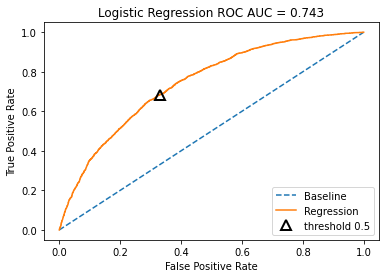

In [34]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.7825594022071245, penalty='l2')
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_val)
y_prob = y_prob[:,1]


fpr, tpr, threshold = roc_curve(y_val, y_prob)
roc_auc = roc_auc_score(y_val, y_prob)
close_default = np.argmin(np.abs(threshold - 0.5))

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10,\
    label="threshold 0.5", fillstyle="none", c='k', mew=2)
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Kривая ROC(кривая рабочих характеристик приемника) обычно используется для анализа поведения классификаторов при
различных пороговых значениях. Она учитывает все возможные пороговые значения для данного классификатора и показывает
частоту ложных срабатываний (FPR): $$ FPR = \frac{FP}{FP+TN} $$
против истинной положительной скорости (TPR): $$ TPR = \frac{TP}{TP+FN} $$ 
TPR - это просто другое название для recall,в то время как FPR - это доля ложных срабатываний из всех отрицательных выборок.

Для кривой ROC идеальная кривая находится близко к верхнему левому краю: нам нужен классификатор, который
обеспечивает высокий отзыв при сохранении низкой частоты ложных срабатываний.

Используя функцию roc_auc_score можно получить площадь под данной кривой AUC. Чем ближе этот показатель к 1, тем лучше модель.
Данная метрика хороша тем, что в зависимости от конкретной бизнес-цели можно посредством показателя порога модели можно получать достаточно точные прогнозы. Она хорошо интерпретируемая, но также как и гиперпараметры требует настройки(по умолчанию не работает)

Для задач классификации с несбалансированными классами использование AUC для выбора модели часто гораздо более значимо, чем использование точности. Что хорошо показано в "Introduction to machine learning with Python"(Сh 5)


In [35]:
y_pred = model.predict(X_val)

In [36]:
len(y_pred)

14760

**Данная диаграмма показывает, что в нашем наборе из 14760(100%) клиентов 1827(~12.5%) - это плохие заемщики, при этом модель распознала
1242(8.41%) из них и не распознала 585(3.96%), отнеся их к добропорядочным. При этом 4290(29.07%) клиентов модель посчитала непорядочными, а это будет упущенная выгода.**

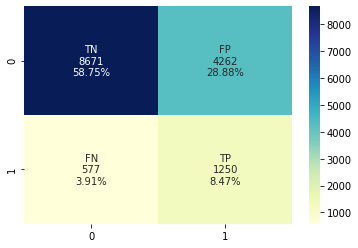

In [37]:
show_confusion_matrix(y_val, y_pred)

**Теперь посмотрим, как влияет изменения порога отсечения модели на матрицу неточностей.
Попробуем отсечь значения с P>=0.9 и с P>=0.3
ПРи P>=0.9 модель уже не распознает плохих заемщиков почти совсем: распознано только 0.18 из 12.38, но при этом и процент отнесения порядочных заемщиков к потенциальным неплательщикам упал до 0.27%, увеличив распознавание действительно надежных клиентов до 87.35%**

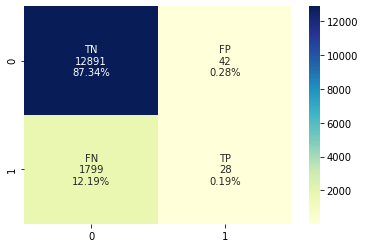

In [38]:
y_prob_2 = (model.predict_proba(X_val)[:,1] >=0.9).astype('int32')
show_confusion_matrix(y_val, y_prob_2)

**При P>=0.3 ситуация меняется координально: модель распознает неплательщиков почти полностью: 11.65% из 12.38, неверно отнесено к благонадежным клиентам 0.72%, а вот количество неверно отнесенных к неблагонадежным добросовестных клиентов увеличилось уже до 60.61% от всего числа клиентов.
Таким образом, используя порог отсечения взависимости от конкретной бизнес-задачи можно увеличивать вероятность распознавания того или иного класса.**

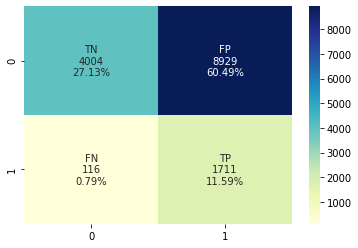

In [39]:
y_prob_2 = (model.predict_proba(X_val)[:,1] >=0.3).astype('int32')
show_confusion_matrix(y_val, y_prob_2)

In [40]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



**Вот таким получается время обучения модели с расчетом ROC AUC на отложенной выборке**

In [41]:
%%time
get_auc_lr(X_train, y_train, X_val, y_val)

CPU times: user 46.2 ms, sys: 36.5 ms, total: 82.7 ms
Wall time: 13.9 s


0.7430709262350852

**Выберем признаки, которые сильнее всего коррелируют с целевой переменной**

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   education         73799 non-null  int64  
 2   sex               73799 non-null  int64  
 3   age               73799 non-null  int64  
 4   car               73799 non-null  int64  
 5   car_type          73799 non-null  int64  
 6   decline_app_cnt   73799 non-null  int64  
 7   good_work         73799 non-null  int64  
 8   score_bki         73799 non-null  float64
 9   bki_request_cnt   73799 non-null  int64  
 10  region_rating     73799 non-null  int64  
 11  home_address      73799 non-null  int64  
 12  work_address      73799 non-null  int64  
 13  income            73799 non-null  int64  
 14  sna               73799 non-null  int64  
 15  first_time        73799 non-null  int64  
 16  foreign_passport  73799 non-null  i

In [43]:
dictFeatures = OrderedDict()
for j in df_train.columns:
    print(j,abs(round(df_train['default'].corr(df_train[j]),3)))
    if abs(round(df_train['default'].corr(df_train[j]),3)) <1:
        dictFeatures[abs(round(df_train['default'].corr(df_train[j]),3))] = j

client_id 0.039
education 0.074
sex 0.02
age 0.025
car 0.043
car_type 0.057
decline_app_cnt 0.114
good_work 0.043
score_bki 0.175
bki_request_cnt 0.078
region_rating 0.089
home_address 0.085
work_address 0.082
income 0.04
sna 0.126
first_time 0.106
foreign_passport 0.067
default 1.0
dd 0.006
mm 0.037
doy 0.039
dow 0.001
weekend 0.005


In [44]:
new_d = OrderedDict(sorted(dictFeatures.items()))
new_d

OrderedDict([(0.001, 'dow'),
             (0.005, 'weekend'),
             (0.006, 'dd'),
             (0.02, 'sex'),
             (0.025, 'age'),
             (0.037, 'mm'),
             (0.039, 'doy'),
             (0.04, 'income'),
             (0.043, 'good_work'),
             (0.057, 'car_type'),
             (0.067, 'foreign_passport'),
             (0.074, 'education'),
             (0.078, 'bki_request_cnt'),
             (0.082, 'work_address'),
             (0.085, 'home_address'),
             (0.089, 'region_rating'),
             (0.106, 'first_time'),
             (0.114, 'decline_app_cnt'),
             (0.126, 'sna'),
             (0.175, 'score_bki')])

In [45]:
i = 0
features = []
for item in reversed(new_d):
    if i < 10:
        features.append(new_d[item])
    i += 1    
    #print(item,new_d[item] )
print(features)

['score_bki', 'sna', 'decline_app_cnt', 'first_time', 'region_rating', 'home_address', 'work_address', 'bki_request_cnt', 'education', 'foreign_passport']


<AxesSubplot:>

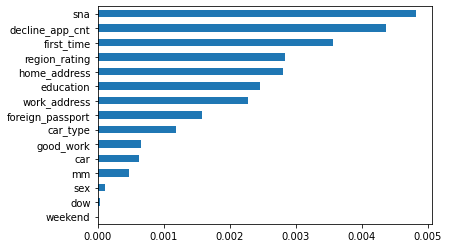

In [46]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

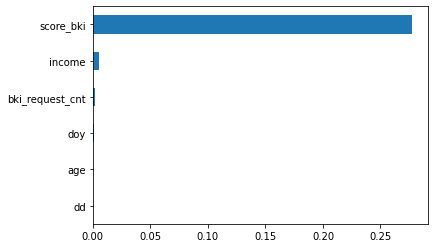

In [47]:
imp_cat = Series(mutual_info_classif(df[num_cols], df['default'],
                                     discrete_features =True), index = num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

**Как видно из произведенного анализа признаки sex, dow,weekend,bki_request_cnt,age,dd на целевой признак влияния почти не оказывают и могут быть кандидатами на исключение из модели. Интересно, что и признак income в чистом виде для модели выглядит совсем непривлекательно.**

**В проекте для отсечения сгенерированных признаков использовалась функция SelectPercentile:**

    select = SelectPercentile(percentile=50)
    select.fit(X, y)
    # transform training set
    print('SelectPercentile:', X.shape, X_test.shape)
    X_selected = select.transform(X)
    X_test_selected = select.transform(X_test)

<a id='8'></a> 
## EDA

**Посмотрим соотношение наличие и отсутствие дефолта у клиентов**

In [48]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'weekend']
cat_cols = ['education', 'home_address', 'work_address', 'decline_app_cnt', \
            'first_time', 'sna', 'region_rating','dow','mm']
num_cols = ['age', 'income', 'bki_request_cnt','score_bki','dd', 'doy']
#df = clear_dataset()


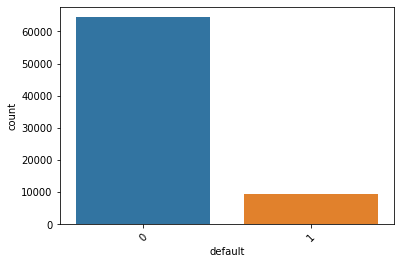

In [49]:
sns.countplot(x='default', data=df[df['sample']==1]);#для train
plt.xticks(rotation=45);

##### На основании гистограммы целевой функции "default" можно сделать следующий вывод:
##### из-за явного дисбаланса выборки, когда клиентов с дефолтом значительно меньше, чем без дефолта,
##### нельзя использовать метрики, не учитывающие веса классов.
##### Как решения возможны:
##### 1. Использование метрик : precision, recall, F1 - score
##### 2. Изменение выборки путем oversampling'а или undersampling'a
##### 3. Добавление штрафа в оптимизационный функционал, прямо пропорционально количеству объектов каждого класса

### Числовые признаки

**Посмотрим на числовые данные с помощью визуализации**

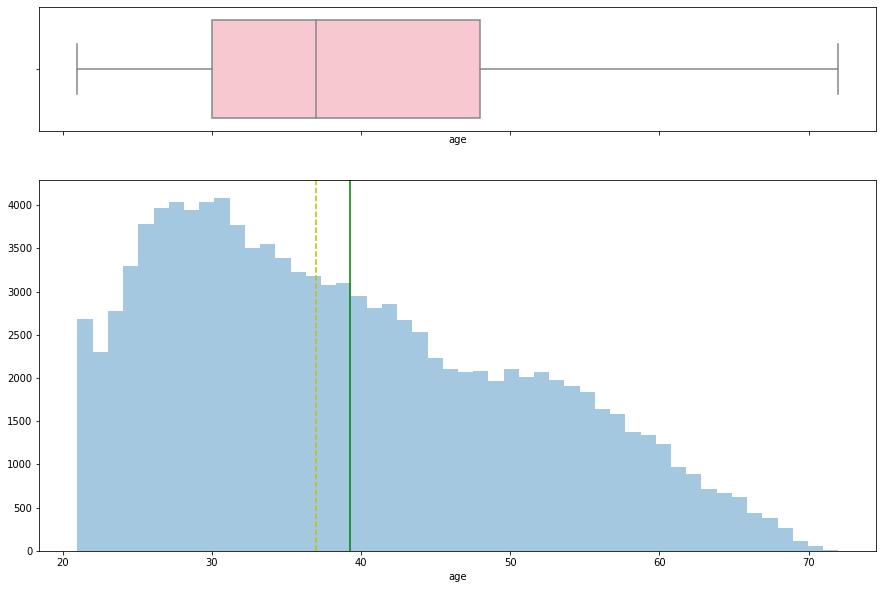

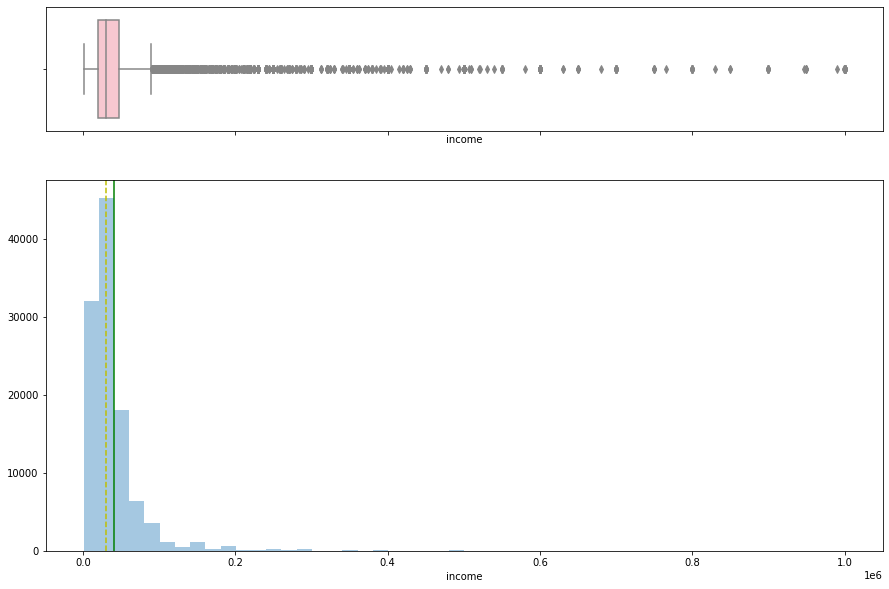

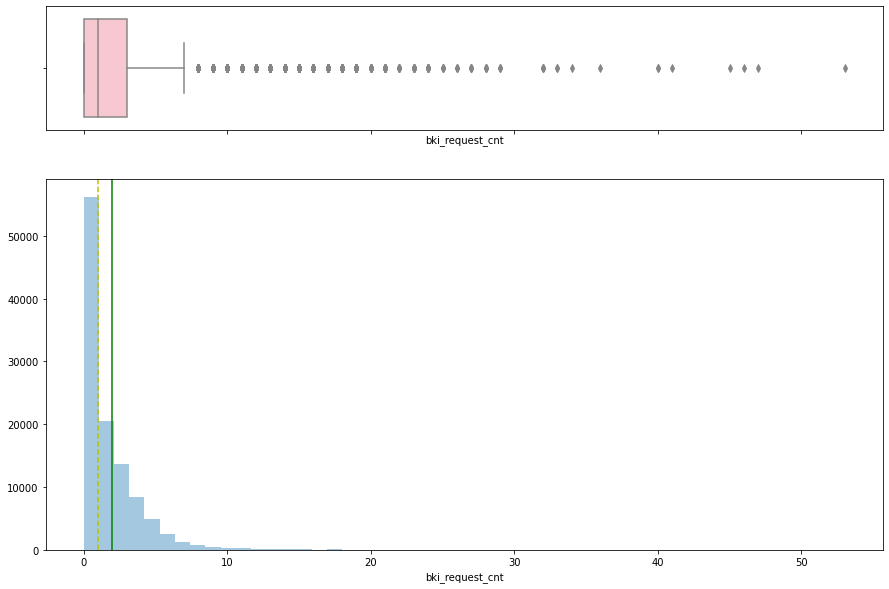

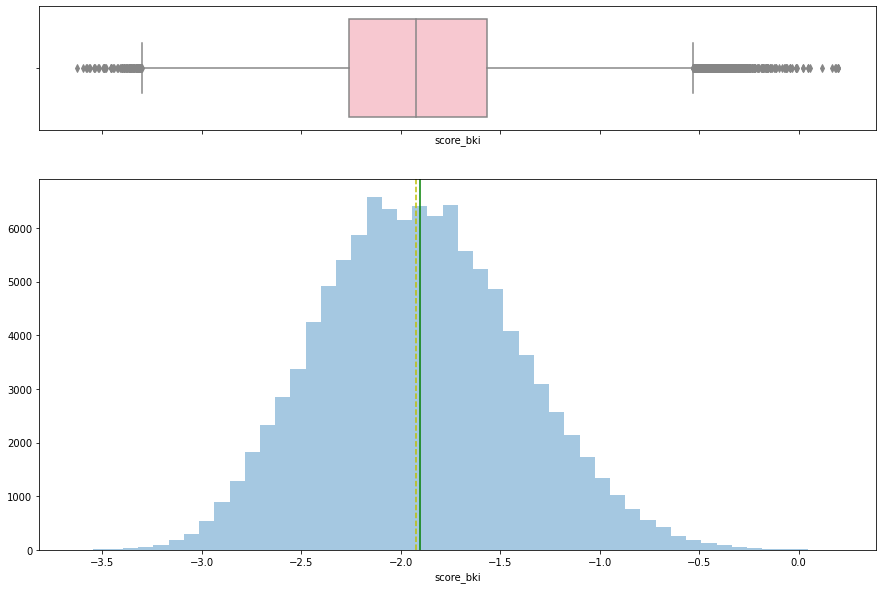

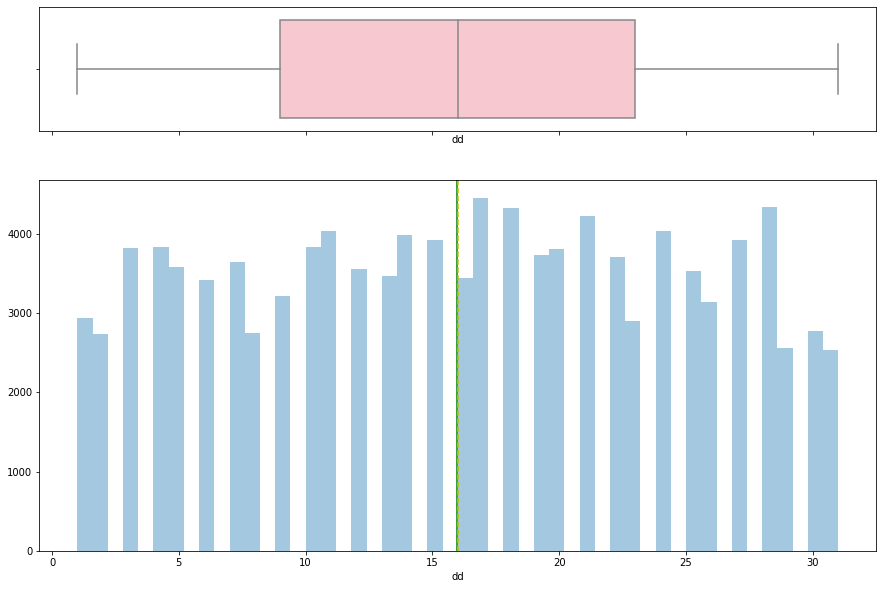

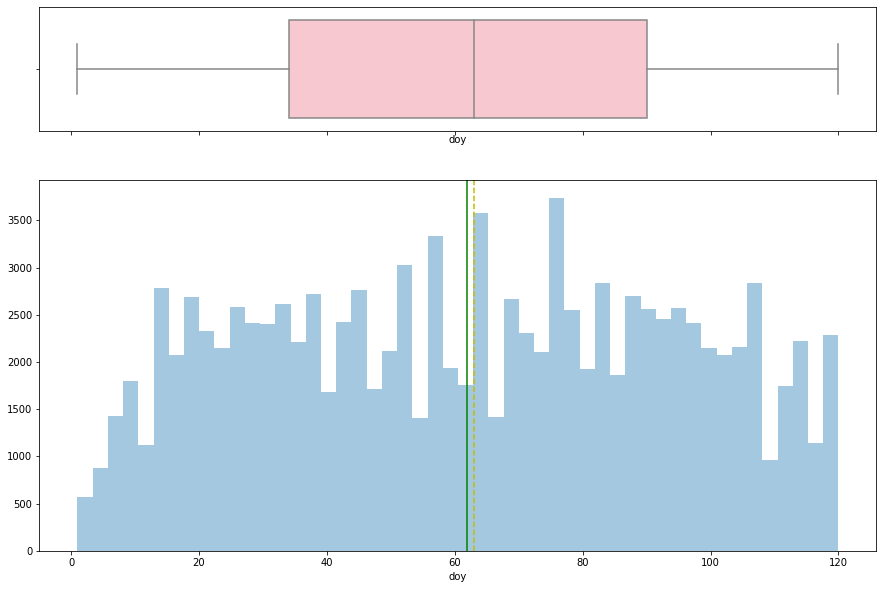

In [50]:
for col in num_cols:
    histogram_boxplot(df[col], figsize=(15,10), bins=None)

**Age - выбросов нет, но само распределение далеко от нормального**

**Income, bki_request_cnt - имеют большое количество выбросов и распределения имеют длинный правый хвост**

**Score_bki - имеет практически идеальную форму, но имеют выбросы как в большую, так и в меньшую стороны**

**Dd, doy - тоже можно попробовать прологарифмировать**

**Для bki_request_cnt, income уберем выбросы**

In [51]:
df[num_cols].agg(['count','min','max','mean','std'])

age          income  bki_request_cnt      score_bki  \
count  110148.000000   110148.000000    110148.000000  110148.000000   
min        21.000000     1000.000000         0.000000      -3.624586   
max        72.000000  1000000.000000        53.000000       0.199773   
mean       39.249410    41012.648537         2.005002      -1.904535   
std        11.518063    45399.735051         2.266926       0.499397   

                  dd            doy  
count  110148.000000  110148.000000  
min         1.000000       1.000000  
max        31.000000     120.000000  
mean       15.959100      61.971466  
std         8.598467      32.076078

### Выбросы

**Уберем выбросы в score_bki:**

In [52]:
low, high = IQR_outlier(df,'score_bki')
df['score_bki'] = df['score_bki'].apply(lambda x: x if x>low else low)
df['score_bki'] = df['score_bki'].apply(lambda x: x if x<high else high)

score_bki
25-й перцентиль: -2.26 75-й перцентиль: -1.568, IQR: 0.6919999999999997,  Границы выбросов: [-3.297999999999999, -0.5300000000000005].


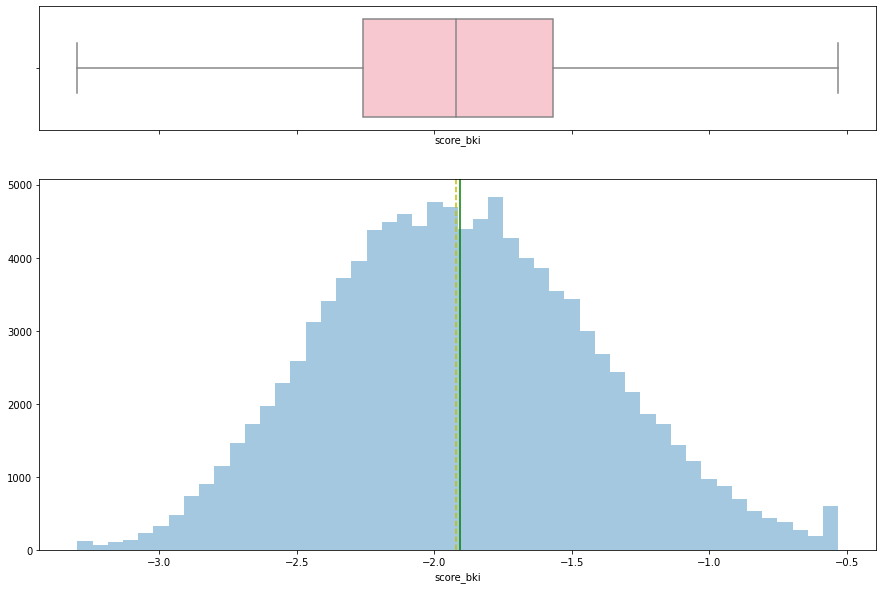

In [53]:
histogram_boxplot(df['score_bki'], figsize=(15,10), bins=None)

**Попробуем прологарифмировать столбцы 'age','income','bki_request_cnt', потом убрать выбросы - это будут числовые признаки.
Для столбца income, значения которого лежат в пределах от 1000 до 1000000 вряд ли будет разумным считать значения выше 90000, определяемые IQR-статистикой выбросами, тем более что, например доход в 100000 имеется у 2056 клиентов, можно попробовать сделать дискретизацию данных. Тем самым получим дополнительные категориальные**

In [54]:
#df['dd'] = np.log(1 + df['dd'])
df['doy'] = np.log(1 + df['doy'])
cols_log = ['age','income','bki_request_cnt']
for col in cols_log:
    df[col+'_log'] = np.log(1 + df[col])
    

dict_cols ={'income':[['10', '50', '100','150','200','500','1000'],\
                      [0, 10000, 50000, 100000, 150000,200000,500000,1000000]],\
               'age':[['35', '48','65','75'],\
                     [20, 35, 48, 65, 75]],\
                'bki_request_cnt':[['0','1', '5', '10','15','30','50','100'],\
                                  [-1,0, 1, 5, 10,15,30,50,100]]               
               }
pd_cut(dict_cols) #Вызов процедуры дискретизации

In [55]:
df['income'].value_counts() #Это ужк категории

50      83411
100     15840
10       6232
150      2665
200       947
500       933
1000      120
Name: income, dtype: int64

<AxesSubplot:>

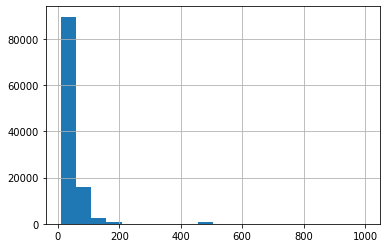

In [56]:
df['income'].hist(bins=20)

<AxesSubplot:>

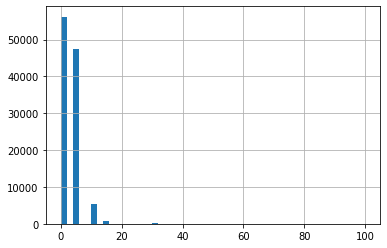

In [57]:
df['bki_request_cnt'].hist(bins=50)

**Возможно все то, что >20 это действительно выбросы**

**Для прологарифмированных столбцов распределения выглядят следующим образом:**

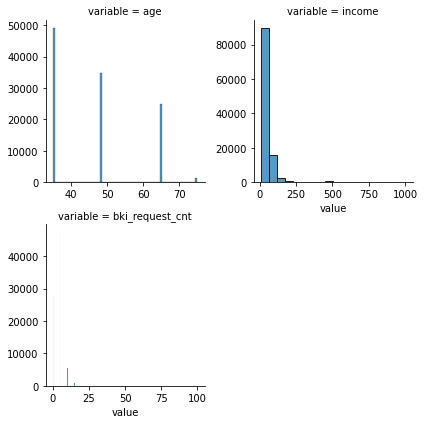

In [58]:
#Для прологарифмированных столбцов
f = pd.melt(df, value_vars=cols_log)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.histplot, "value")

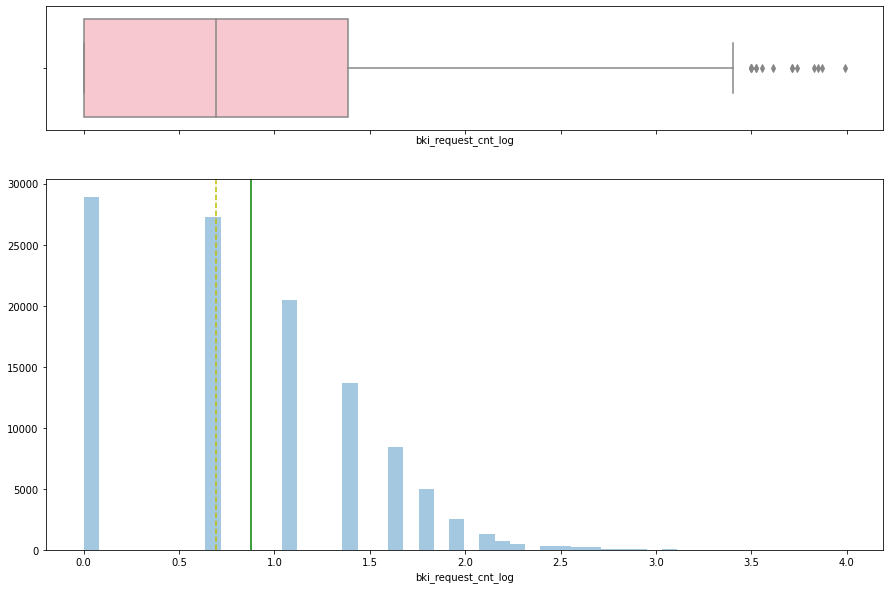

In [59]:
histogram_boxplot(df['bki_request_cnt_log'], figsize=(15,10), bins=None)

In [60]:
low, high = IQR_outlier(df,'bki_request_cnt_log')
df['bki_request_cnt_log'] = df['bki_request_cnt_log'].apply(lambda x: x if x<high else high)

bki_request_cnt_log
25-й перцентиль: 0.0 75-й перцентиль: 1.386, IQR: 1.386,  Границы выбросов: [-2.0789999999999997, 3.465].


**После удаления выбросов:**

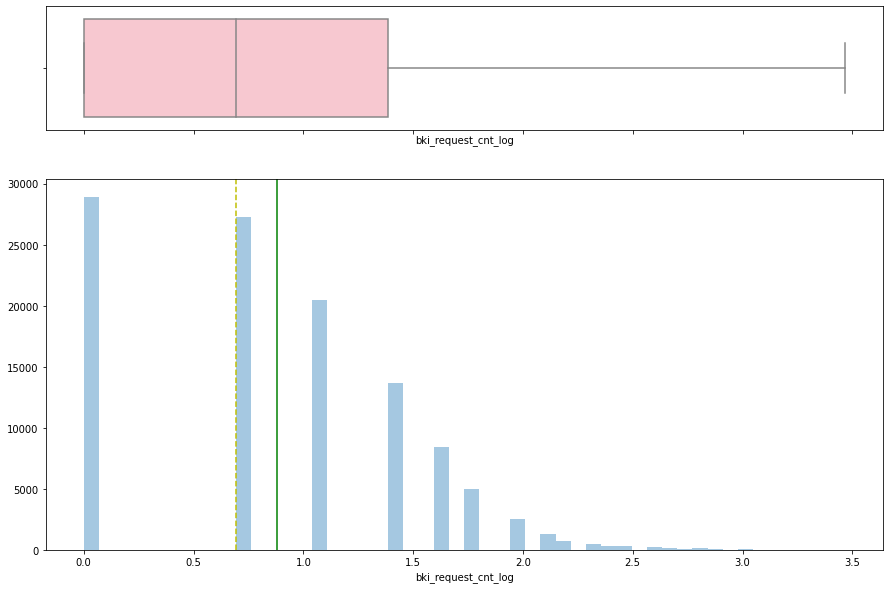

In [61]:
histogram_boxplot(df['bki_request_cnt_log'], figsize=(15,10), bins=None) 

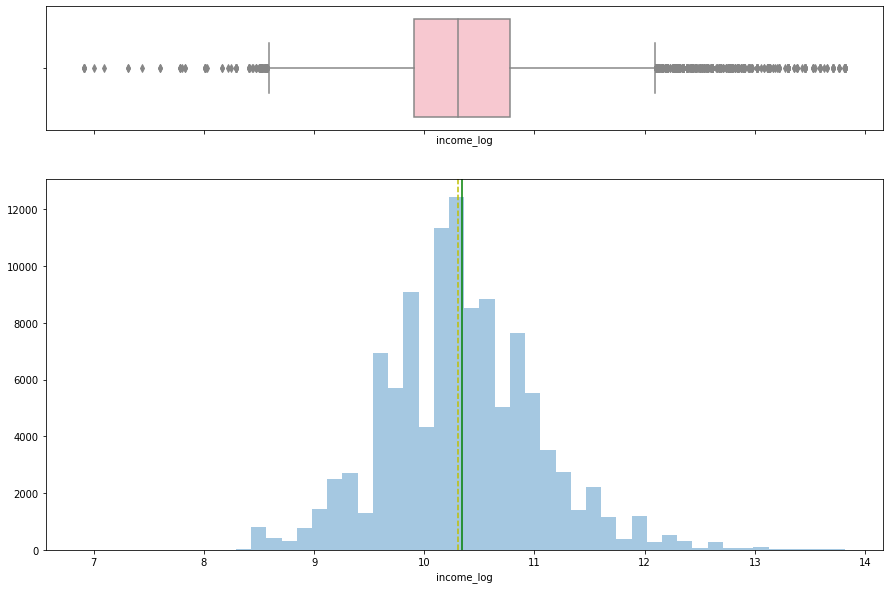

In [62]:
histogram_boxplot(df['income_log'], figsize=(15,10), bins=None)

In [63]:
low, high = IQR_outlier(df,'income_log')
df['income_log'] = df['income_log'].apply(lambda x: x if x>low else low)
df['income_log'] = df['income_log'].apply(lambda x: x if x<high else high)

income_log
25-й перцентиль: 9.904 75-й перцентиль: 10.779, IQR: 0.875,  Границы выбросов: [8.5915, 12.0915].


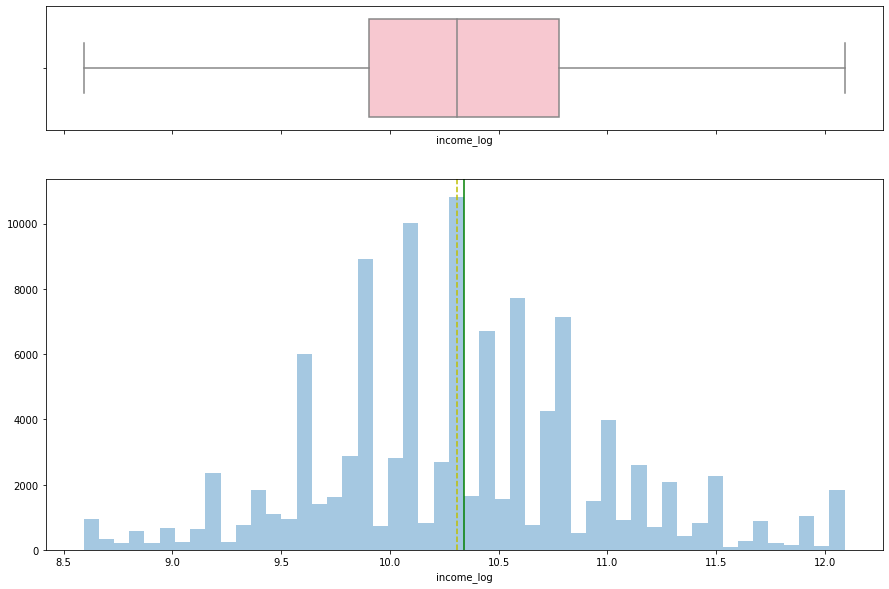

In [64]:
histogram_boxplot(df['income_log'], figsize=(15,10), bins=None)

In [65]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'weekend']
cat_cols = ['education', 'home_address', 'work_address', 'decline_app_cnt', \
            'first_time', 'sna', 'region_rating','dow','mm','age', 'income', 'bki_request_cnt']
num_cols = ['score_bki','dd', 'doy','age_log', 'income_log', 'bki_request_cnt_log']

### Категориальные данные

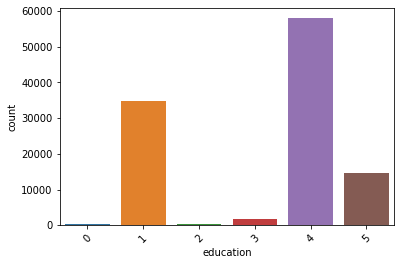

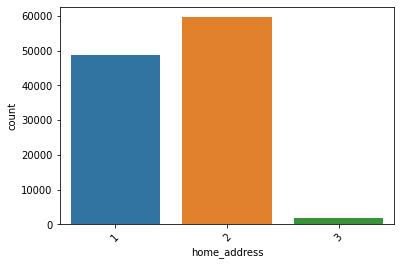

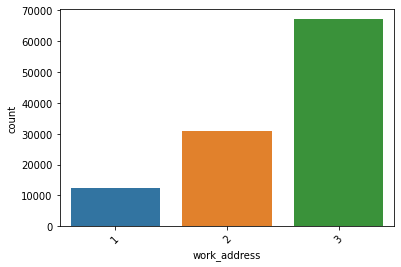

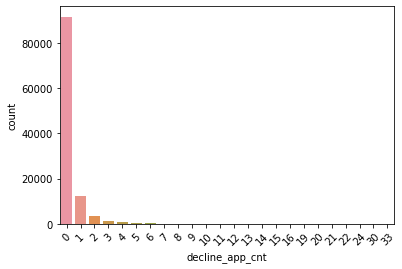

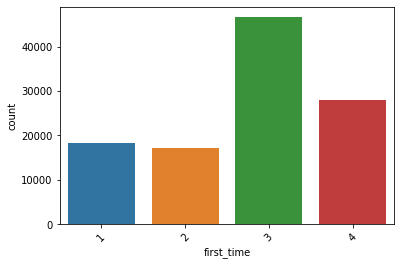

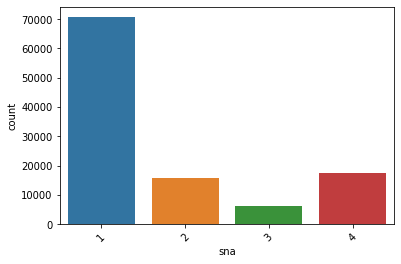

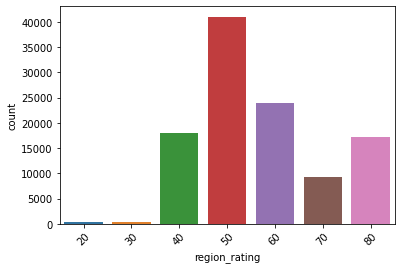

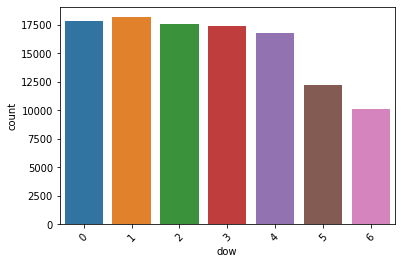

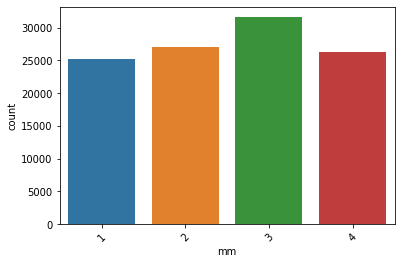

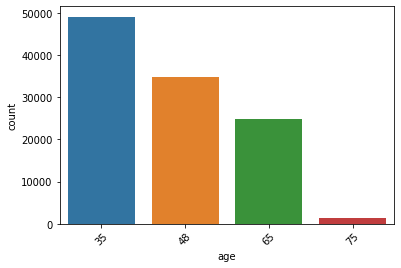

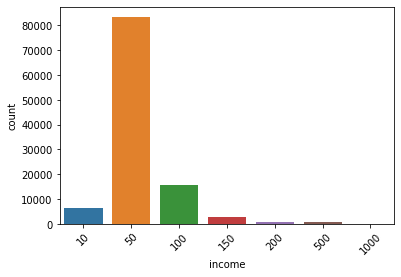

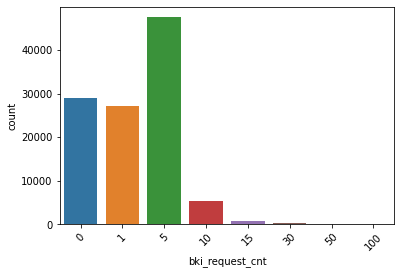

In [66]:
for i in cat_cols:
    sns.countplot(x=i, data=df);
    plt.xticks(rotation=45);
    plt.show();

**Из dow сделать бинарный признак weekend: выходной -5,6 или будний день**

In [67]:
df['weekend'] = df['dow'].apply(lambda x: 1 if x>4 else 0)

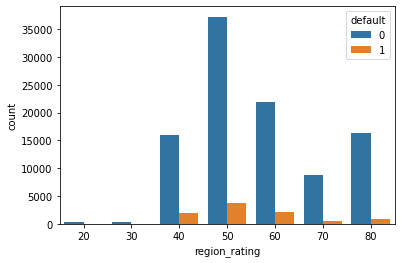

In [68]:
sns.countplot(x='region_rating', hue='default', data=df);

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   client_id            110148 non-null  int64  
 1   education            110148 non-null  int64  
 2   sex                  110148 non-null  int64  
 3   age                  110148 non-null  int32  
 4   car                  110148 non-null  int64  
 5   car_type             110148 non-null  int64  
 6   decline_app_cnt      110148 non-null  int64  
 7   good_work            110148 non-null  int64  
 8   score_bki            110148 non-null  float64
 9   bki_request_cnt      110148 non-null  int32  
 10  region_rating        110148 non-null  int64  
 11  home_address         110148 non-null  int64  
 12  work_address         110148 non-null  int64  
 13  income               110148 non-null  int32  
 14  sna                  110148 non-null  int64  
 15  first_time       

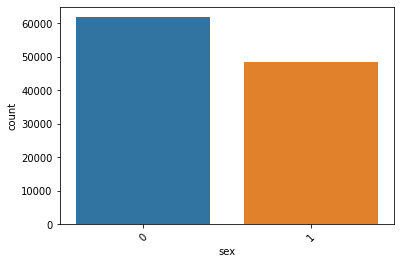

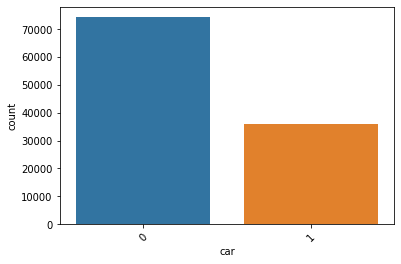

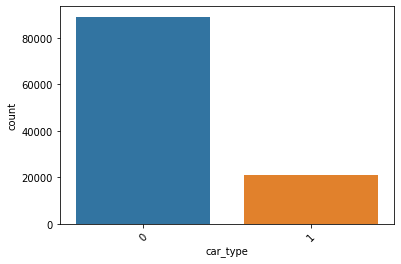

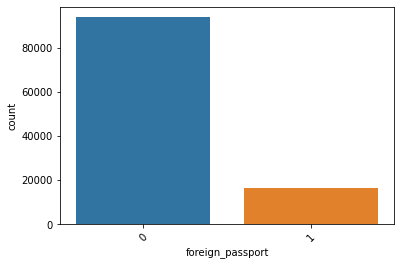

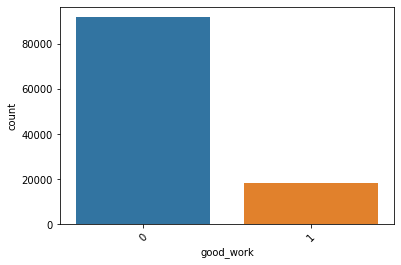

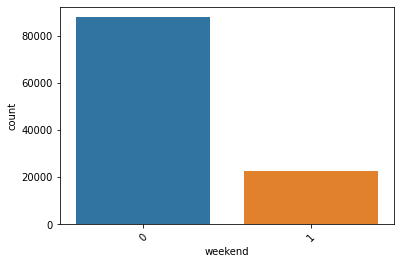

In [70]:
for i in bin_cols:
    sns.countplot(x=i, data=df);
    plt.xticks(rotation=45);
    plt.show();

#### Взаимодействие признаков

##### 1. Числовые признаки требуют работы с выбросами
##### 2. Средний возраст дефолтных клиентов немного меньше, чем недефолтных
##### 3. У дефолтных клиентов в прошлом было больше отказов по заявкам,
##### как и само количество запросов в БКИ
##### 4. Средний доход и разброс в уровне дохода у дефолтных клиентов меньше
##### 5. Скоринговый балл по данным из БКИ: минимум, максимум, медиана и разброс для дефолтных
##### клиентов больше, чем для недефолтных.

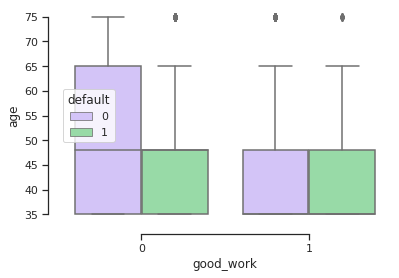

In [71]:
grouped_boxplots(df,'good_work','age','default')

**Интересно, что хорошую работу имеют по большей части люди до 46 лет, что не мешает им стать плохими заемщиками,
а вот выбросы в районе 70 лет говорят о людях, занимающих какие-либо высокие должности.**

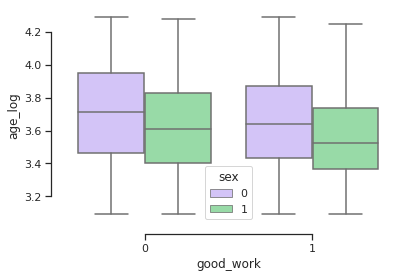

In [72]:
grouped_boxplots(df,'good_work','age_log','sex')

**Sex - совершенно никчемный признак на выброс, оказывается все-таки работает в связке возрастом и работой.**

In [73]:
df['sex_work'] = df['sex'].astype('int')*10 + df['good_work'].astype('int')
df['sex_age'] = df['age'].astype('int')*(~df['sex']).astype('int')

In [74]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'weekend']
cat_cols = ['education', 'home_address', 'work_address', 'decline_app_cnt', 'sex_work',\
            'first_time', 'sna', 'region_rating','dow','mm','age', 'income', 'bki_request_cnt']
num_cols = ['score_bki','dd', 'doy','age_log', 'income_log', 'bki_request_cnt_log']

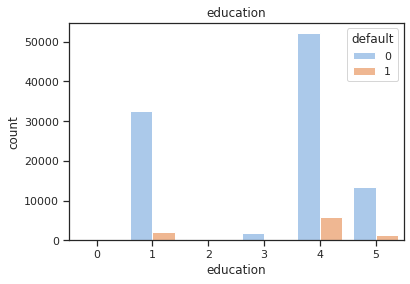

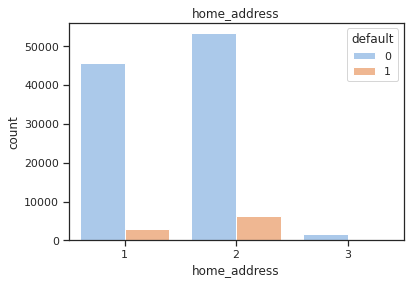

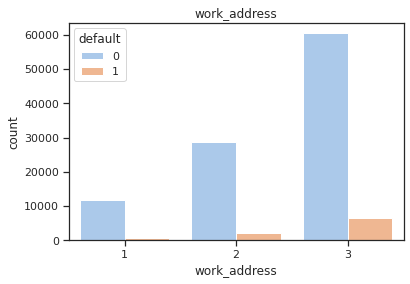

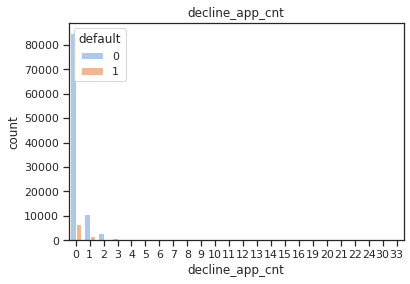

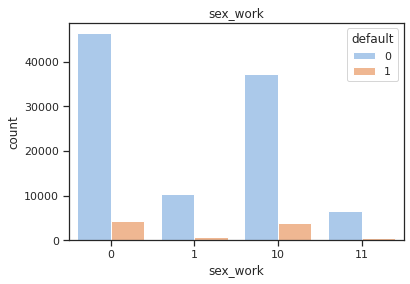

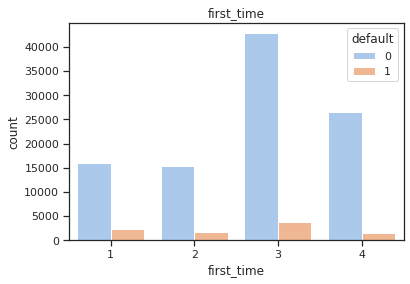

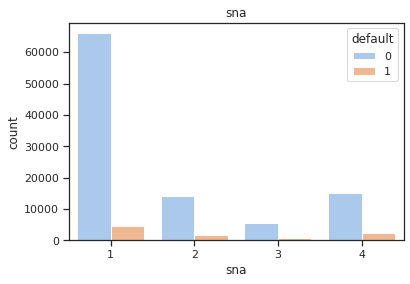

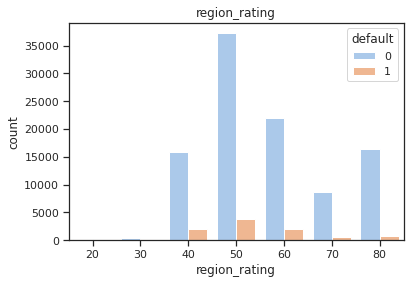

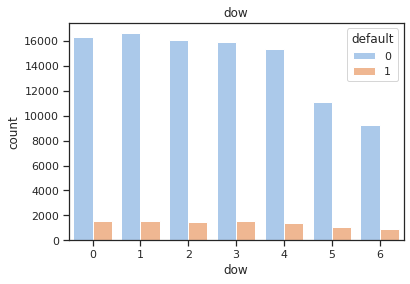

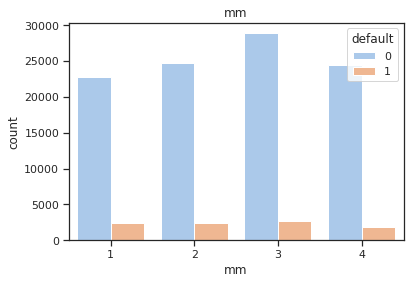

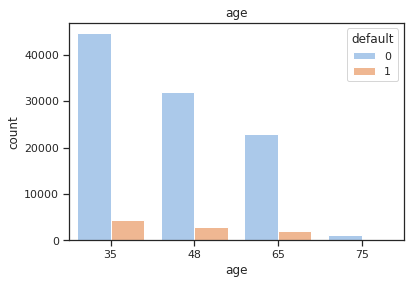

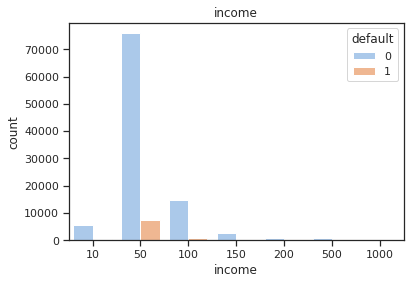

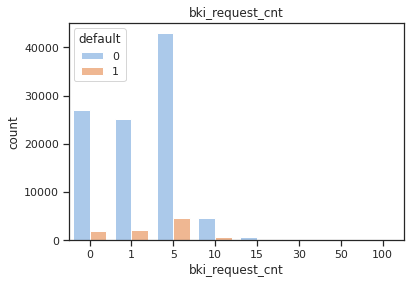

In [75]:
for i in cat_cols:
    plt.figure()
    #sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    ax = sns.countplot(x=df[i], hue="default", data=df)
    plt.title(i)
    plt.show()

**Dow явно требует доработки**

<a id='5'></a> 
## Корреляционный анализ

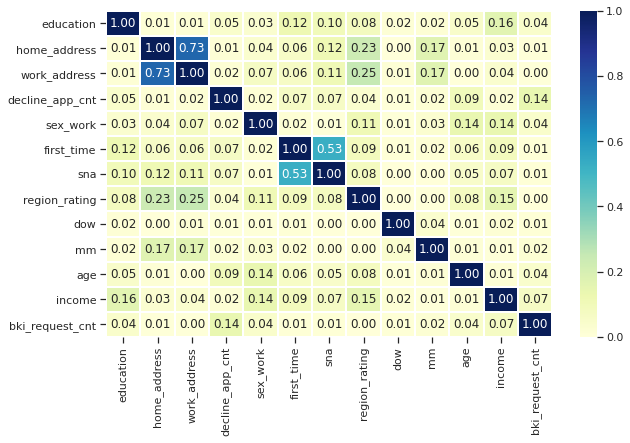

In [76]:
# Построим матрицу корреляций для категориальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[cat_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu");


**На диаграмме видна хорошая корреляция двух пар признаков:
work_address - home_address
sna - first_time
Изобразим следующие диаграммы:**

**Из каждой пары признаков сделаем по категориальному признаку, который будет нести информацию обоих признаков.**

In [77]:
df['home_work_address'] = df['home_address']*10+df['work_address']
df['sna_first_time'] = df['sna']*10+df['first_time']
df.drop(columns = ['home_address','work_address','sna','first_time'], inplace=True)

In [78]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'weekend']
cat_cols = ['education', 'home_work_address', 'decline_app_cnt', 'sex_work',\
            'sna_first_time', 'region_rating','dow','mm','age', 'income', 'bki_request_cnt']
num_cols = ['score_bki','dd', 'doy','age_log', 'income_log', 'bki_request_cnt_log']

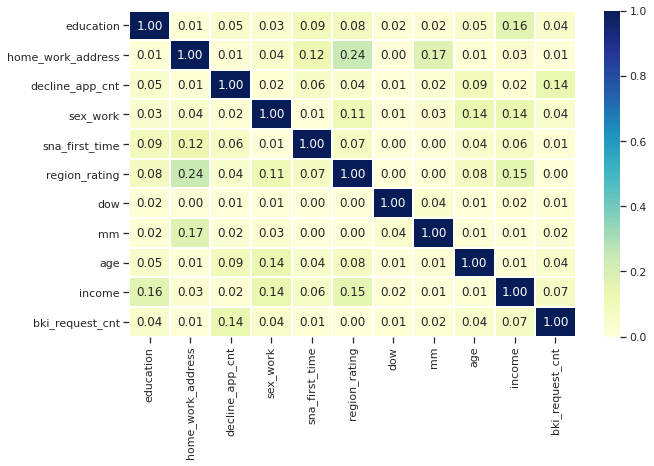

In [79]:
# Построим матрицу корреляций для категориальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[cat_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu");

**Теперь категориальные признаки достаточно слабо коррелируют друг с другом и годятся для моделирования**

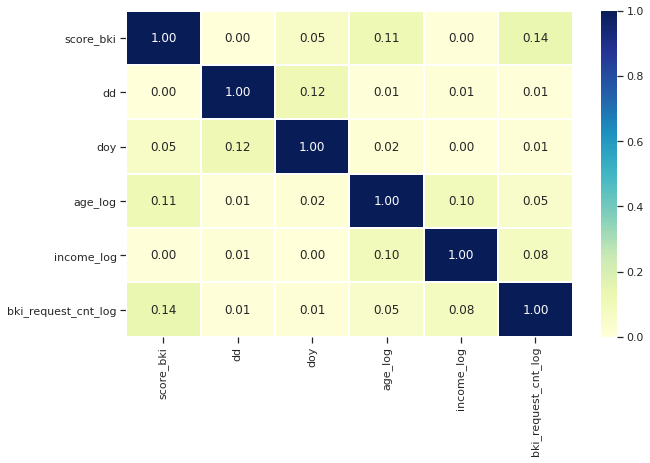

In [80]:
# Построим матрицу корреляций для числовых признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu");

##### На основании данного графика можно сделать выводы, что 
##### численные переменные годятся для построения линейных моделей потому, что почти не коррелируют друг с другом.

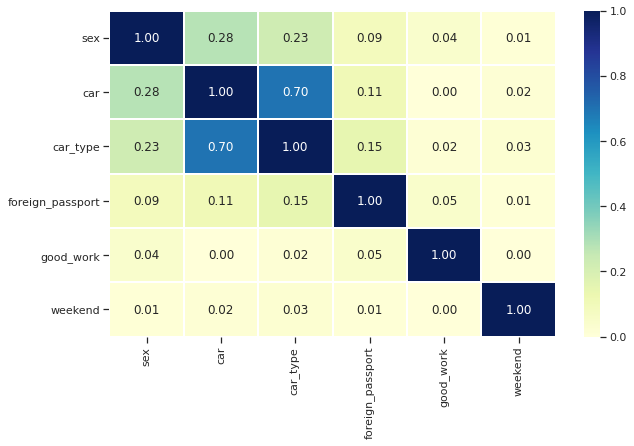

In [81]:
# Построим матрицу корреляций для ,биноминальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu");

**Сильная корреляция между car - car_type**

**Чтобы избавиться от зависимости двух биномиальных признаков введем один категориальный,
который будет нести информацию не только о наличии у клиента машины, но и ее типа:**

In [82]:
df['cars'] = df['car'].astype('int')*10 + df['car_type'].astype('int')
df.drop(columns = ['car','car_type'], inplace=True)
df['mdow'] = df['dow']*df['mm'].astype('int')

In [83]:
bin_cols = ['sex', 'foreign_passport', 'good_work', 'weekend']
cat_cols = ['education', 'home_work_address', 'decline_app_cnt', 'sex_work', 'cars', 'mdow',\
            'sna_first_time', 'region_rating','age', 'income', 'bki_request_cnt']
num_cols = ['score_bki','dd', 'doy','age_log', 'income_log', 'bki_request_cnt_log']

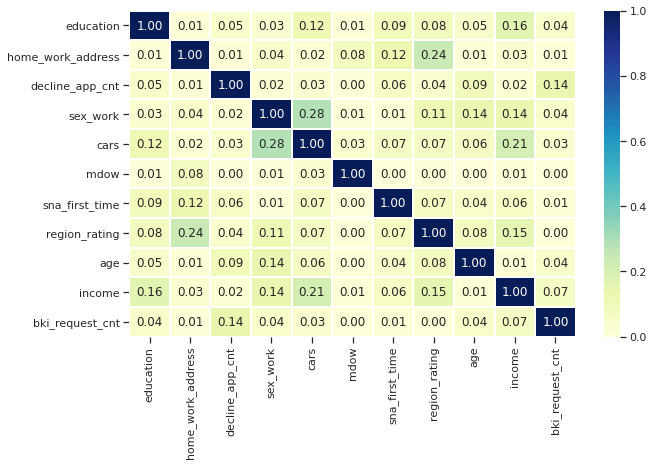

In [84]:
# Построим матрицу корреляций для ,биноминальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[cat_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu");

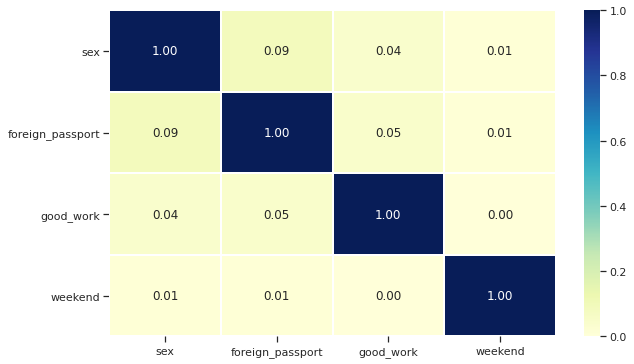

In [85]:
# Построим матрицу корреляций для ,биноминальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1, cmap="YlGnBu");

In [86]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 0 to 36348
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   education         36349 non-null  int64  
 2   sex               36349 non-null  int64  
 3   age               36349 non-null  int64  
 4   car               36349 non-null  int64  
 5   car_type          36349 non-null  int64  
 6   decline_app_cnt   36349 non-null  int64  
 7   good_work         36349 non-null  int64  
 8   score_bki         36349 non-null  float64
 9   bki_request_cnt   36349 non-null  int64  
 10  region_rating     36349 non-null  int64  
 11  home_address      36349 non-null  int64  
 12  work_address      36349 non-null  int64  
 13  income            36349 non-null  int64  
 14  sna               36349 non-null  int64  
 15  first_time        36349 non-null  int64  
 16  foreign_passport  36349 non-null  int64 

#### Значимость непрерывных переменных

<AxesSubplot:>

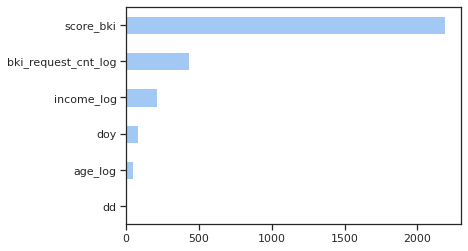

In [87]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

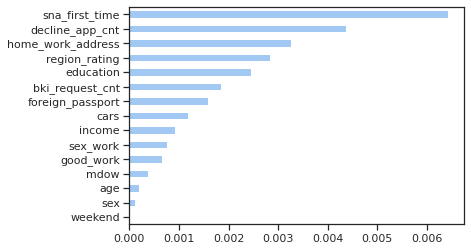

In [88]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

**Как видно из графика признаки mm, sex, weekend являются малозначимыми**

**Остановимся на следующих признаках:**

In [89]:
bin_cols = ['foreign_passport', 'good_work']
cat_cols = ['sna_first_time', 'decline_app_cnt', 'home_work_address', 'region_rating', \
            'education', 'bki_request_cnt', 'cars', 'income', 'sex_work', 'mdow','age']
num_cols = ['score_bki','bki_request_cnt_log', 'income_log','doy','age_log']

<a id='10'></a> 
### Настройка гиперпараметров логистической регрессии

In [90]:
#model

In [91]:
# Create param grid.
#C = np.logspace(0, 4, 10).tolist()

#param_grid = [
#    {'penalty': ['l1','l2'],
#     'C' : C,
#     'solver': ['liblinear', 'lbfgs'],
#     'class_weight':['balanced'],
#     'multi_class': ['auto']}
#    ]
'''
penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)
# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
'''
'''
Лучшее Penalty: l2
Лучшее C: 2.7825594022071245
'''


# Create grid search object

#clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

#best_clf = clf.fit(X_train, y_train)
'''
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
best_clf = gridsearch.fit(X_train, y_train)

print("Best parameter (CV score=%0.6f):" % gridsearch.best_score_)
print(gridsearch.best_params_)
Best parameter (CV score=0.342727):
{'C': 1.0, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
'''

'\ngridsearch = GridSearchCV(model, param_grid, scoring=\'f1\', n_jobs=-1)\nbest_clf = gridsearch.fit(X_train, y_train)\n\nprint("Best parameter (CV score=%0.6f):" % gridsearch.best_score_)\nprint(gridsearch.best_params_)\nBest parameter (CV score=0.342727):\n{\'C\': 1.0, \'class_weight\': \'balanced\', \'multi_class\': \'auto\', \'penalty\': \'l1\', \'solver\': \'liblinear\'}\n'

In [92]:
#best_model.best_estimator_.get_params()['C']
#best_model

In [93]:
#Поиск параметров методом решетки
#_GridSearchCV('l1')
#_GridSearchCV('l2')

In [94]:
#Поиск параметров методом случайного поиска

#best_params_, best_score_ = _RandomizedSearchCV()

#'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'auto', 'class_weight': 'none', 'C': 7742.636826811277
#Tuned Decision Tree Parameters: {'solver': 'newton-cg', 'penalty': 'none', 'multi_class': 'ovr', 'class_weight': 'none', 'C': 2154.4346900318847}
#Best score is 0.8725249183285004

#Tuned Decision Tree Parameters: {'solver': 'sag', 'penalty': 'l2', 'multi_class': 'ovr', 'class_weight': 'none', 'C': 46.4158883361278}
#Best score is 0.8729992046310316

<a id='11'></a> 
### Песочница для экспериментов

In [95]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'weekend']
cat_cols = ['education', 'home_address', 'work_address', 'decline_app_cnt', \
            'first_time', 'sna', 'region_rating', 'dow']
num_cols = ['age', 'income', 'bki_request_cnt','score_bki','dd', 'doy']

**Чистый датасет**

In [96]:
df = clear_dataset()

**Добавляем признаки**

In [97]:
convert_dataset()

score_bki
25-й перцентиль: -2.26 75-й перцентиль: -1.568, IQR: 0.6919999999999997,  Границы выбросов: [-3.297999999999999, -0.5300000000000005].
income_log
25-й перцентиль: 9.904 75-й перцентиль: 10.779, IQR: 0.875,  Границы выбросов: [8.5915, 12.0915].
bki_request_cnt_log
25-й перцентиль: 0.0 75-й перцентиль: 1.386, IQR: 1.386,  Границы выбросов: [-2.0789999999999997, 3.465].


client_id  education  sex  age  decline_app_cnt  good_work  score_bki  \
0           74835          1    1   35                0          0  -2.271884   
1           17527          4    0   48                5          0  -1.504999   
2           75683          5    1   65                0          0  -1.691339   
3           26883          4    1   65                0          0  -2.374182   
4           28862          1    0   48                0          0  -2.487502   
...           ...        ...  ...  ...              ...        ...        ...   
110143      54887          1    0   48                0          0  -1.792064   
110144      76821          4    1   48                0          0  -2.058029   
110145     103695          4    1   35                0          0  -1.512635   
110146        861          4    0   35                0          1  -1.479334   
110147      15796          1    1   35                0          0  -1.764711   

        bki_request_cnt  region_rating  income  foreign_passport  sample  \
0                     5             50      50                 0       0   
1                     5             50      10                 0       0   
2                     1             50      50                 1       0   
3                     1             40      50                 0       0   
4                     0             80     150                 0       0   
...                 ...            ...     ...               ...     ...   
110143                5             50      50                 0       1   
110144                1             50     100                 0       1   
110145                5             80      50                 0       1   
110146                5             50      50                 0       1   
110147                5             50      50                 0       1   

        default       doy  mdow  weekend   age_log  income_log  \
0             0  4.406719    15        1  3.401197   10.819798   
1             0  3.218876     4        0  3.688879    8.591500   
2             0  4.418841    18        1  3.931826   10.308986   
3             0  3.555348     0        0  4.043051    9.741027   
4             0  3.583519     2        0  3.663562   11.695255   
...         ...       ...   ...      ...       ...         ...   
110143        0  4.158883     3        0  3.828641    9.741027   
110144        0  4.430817     0        0  3.737670   11.156265   
110145        0  4.727388     4        0  3.465736   10.714440   
110146        1  1.609438     5        1  3.401197    9.472782   
110147        0  3.178054     3        0  3.555348   10.126671   

        bki_request_cnt_log  home_work_address  sna_first_time  cars  \
0                  1.386294                 12              14    11   
1                  1.098612                 12              43     0   
2                  0.693147                 12              13    11   
3                  0.693147                 12              13     0   
4                  0.000000                 23              13     0   
...                     ...                ...             ...   ...   
110143             1.386294                 12              44     0   
110144             0.693147                 22              14    11   
110145             1.609438                 23              22     0   
110146             1.386294                 13              23     0   
110147             1.098612                 23              13     0   

        sex_work  sex_age  
0             10       45  
1              0       48  
2             10       75  
3             10       75  
4              0       48  
...          ...      ...  
110143         0       48  
110144        10       58  
110145        10       45  
110146         1       35  
110147        10       45  

[110148 rows x 24 columns]

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   client_id            110148 non-null  int64  
 1   education            110148 non-null  int64  
 2   sex                  110148 non-null  int64  
 3   age                  110148 non-null  int32  
 4   decline_app_cnt      110148 non-null  int64  
 5   good_work            110148 non-null  int64  
 6   score_bki            110148 non-null  float64
 7   bki_request_cnt      110148 non-null  int32  
 8   region_rating        110148 non-null  int64  
 9   income               110148 non-null  int32  
 10  foreign_passport     110148 non-null  int64  
 11  sample               110148 non-null  int64  
 12  default              110148 non-null  int64  
 13  doy                  110148 non-null  float64
 14  mdow                 110148 non-null  int64  
 15  weekend          

In [99]:

bin_cols = ['foreign_passport', 'good_work']
cat_cols = ['sna_first_time', 'decline_app_cnt', 'home_work_address', 'region_rating', \
            'education', 'bki_request_cnt', 'cars', 'income', 'sex_work', 'mdow','age']
num_cols = ['score_bki','bki_request_cnt_log', 'income_log','doy','age_log']
all_cols = list(set(cat_cols).union(bin_cols,num_cols))

In [100]:
'''
bin_cols = ['foreign_passport']
cat_cols = ['sna_first_time', 'decline_app_cnt', 'home_work_address', 'region_rating', \
            'education', 'bki_request_cnt', 'cars', 'income']
num_cols = ['score_bki']
all_cols = list(set(cat_cols).union(bin_cols,num_cols))
'''

"\nbin_cols = ['foreign_passport']\ncat_cols = ['sna_first_time', 'decline_app_cnt', 'home_work_address', 'region_rating',             'education', 'bki_request_cnt', 'cars', 'income']\nnum_cols = ['score_bki']\nall_cols = list(set(cat_cols).union(bin_cols,num_cols))\n"

In [101]:
X_train, df_test, y_train, X_val, y_val, X_test = preproc_data(df, cat_cols, num_cols, bin_cols)

(73799, 5) (36349, 5)
(73799, 252) (36349, 252)
(73799, 89) (36349, 89)
(73799, 2) (36349, 2)
(73799, 343) (73799,)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [0] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectPercentile: (73799, 343) (36349, 343)
X.shape,X_selected.shape= (73799, 343) (73799, 206)
X_test.shape,X_test_selected.shape= (36349, 343) (36349, 206)
(73799, 206) (73799,) (36349, 206)


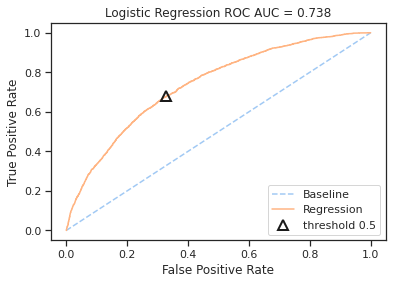

In [102]:
model = logreg_model()

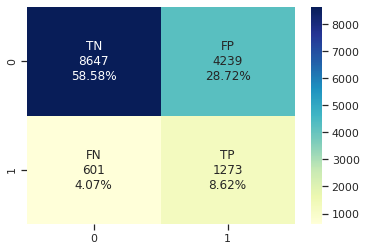

In [103]:
y_pred = model.predict(X_val)
show_confusion_matrix(y_val, y_pred)

In [104]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12886
           1       0.23      0.68      0.34      1874

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



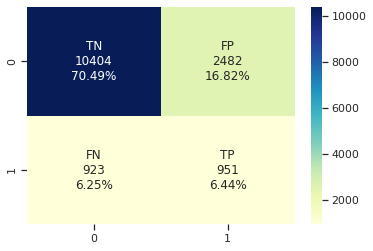

In [105]:
y_prob_2 = (model.predict_proba(X_val)[:,1] >=0.6).astype('int32')
show_confusion_matrix(y_val, y_prob_2)

In [106]:
print(classification_report(y_val,y_prob_2))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86     12886
           1       0.28      0.51      0.36      1874

    accuracy                           0.77     14760
   macro avg       0.60      0.66      0.61     14760
weighted avg       0.84      0.77      0.80     14760



In [107]:
df_test['default'] = model.predict_proba(X_test)[:, 1]

In [108]:
submission = df_test[['client_id', 'default']]
display(submission.sample(10))
submission.to_csv('submission.csv', index=False)

client_id   default
8039       10913  0.519687
20794      78239  0.290883
29336      81821  0.084384
27282      46813  0.585671
13772      87982  0.463662
24027      33024  0.529275
849        48616  0.178715
34551      35313  0.375398
31015      31797  0.956993
4387       29022  0.503434

<a id='13'></a> 
### Выводы

[Рис1](https://disk.yandex.ru/i/scXmNDMlCkCUvw)
**Данный рисунок демонстрирует, что различные модели давая близкий результат AUC, демонтрируют совершенно противоположный результат: всегда нужно помнить о дополнительной регулировке порога отсечения и только тогда сравнивать модели** 

[Рис2](https://disk.yandex.ru/i/QZNf9FeGP-cBhQ)
**Данный рисунок демонстрирует возможности влияния порога отсечения на различные модели**

**В ходе выполнения проекта была построена модель логистической регрессии с настройкой гиперпараметров.
Получить улучшения модели настройкой параметров не удалось. Для подборки параметров использовались GridSearchCV и  RandomizedSearchCV,
последний показал лучшую производительность.**

**Для устранения несбалансированности выборки кроме стратификации в момент разделения выборки не предпринималось ничего.
Для устранения этого недостатка датасета нужно попробовать использовать библиотеки: xgboost, SMOTE  и пр.**
    

model = LogisticRegression(solver='newton-cg', multi_class='ovr', class_weight=None, C=2154.4346900318847, penalty='none')#0.746
    
model = LogisticRegression(max_iter=1000,solver='liblinear', class_weight='balanced', C=1.0, penalty='l1')#0.746
    
model = LogisticRegression(solver='liblinear', class_weight='balanced', C=2.7825594022071245, penalty='l2')#0.743
    
model = LogisticRegression(max_iter=1000,solver='newton-cg', C=7742.636826811277, penalty='l2', multi_class='auto', class_weight=None)#0.747

